In [1]:
import pandas as pd
import os, sys
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from torch._inductor.utils import get_gpu_dram_gbps

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42

In [2]:
dtype_to_peak_fp = {
    "32": 19.5,
    "tf32": 156,
    "16": 312,
    "b16": 312
}

# Note: hard-coded for A100.
beta = 2.03904

def get_dtype_peak_fp(row):
    if row['dtype_32']:
        return dtype_to_peak_fp["32"]
    elif row['dtype_16']:
        return dtype_to_peak_fp["16"]
    elif row['dtype_b16']:
        return dtype_to_peak_fp["b16"]
    else:
        raise ValueError("Unknown dtype in row.")

In [3]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=0.3)
df = pd.concat([X, y], axis=1)

100%|██████████| 72/72 [00:30<00:00,  2.37it/s]


In [4]:
# Note: gflops_per_ms doesn't account for dtype.
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["memory_accesses"] = df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]

# Intensity := flops / memory accesses
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]
df["max_gflops_per_ms"] = df.apply(lambda row: get_dtype_peak_fp(row), axis=1)

In [5]:
# learn the alphas—even for those bound by max_gflops_per_second.

# Hm: this doesn't really do anything, 
df_alpha = df.copy()
df_alpha["alpha"] = df_alpha["gflops_per_ms"] / (beta * df_alpha["intensity"])

In [7]:
X, y = (
    df_alpha[
        [
            "n",
            "m",
            "p",
            "gflops",
            "dtype_16",
            "dtype_32",
            "dtype_b16",
            "memory_accesses",
            "intensity",
        ]
    ],
    df_alpha[["alpha", "time"]],
)

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat = False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261979 entries, 358216 to 121958
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   n                261979 non-null  int64  
 1   m                261979 non-null  int64  
 2   p                261979 non-null  int64  
 3   gflops           261979 non-null  float64
 4   dtype_16         261979 non-null  bool   
 5   dtype_32         261979 non-null  bool   
 6   dtype_b16        261979 non-null  bool   
 7   memory_accesses  261979 non-null  int64  
 8   intensity        261979 non-null  float64
dtypes: bool(3), float64(2), int64(4)
memory usage: 14.7 MB


Train--------
Mean Squared Error: 1.2825048744428397e-05
MAPE: 0.009711215903875648
R-squared: 0.9983285296937541


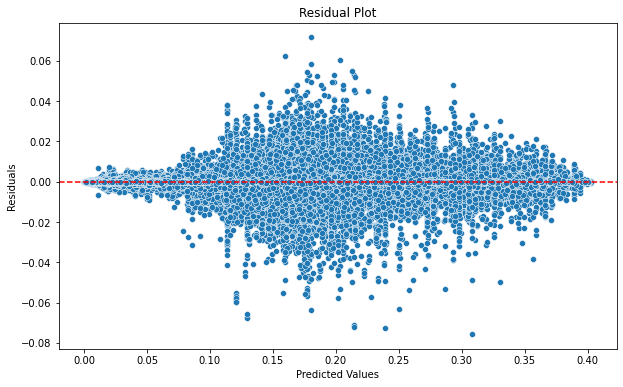

Val--------
Mean Squared Error: 5.4222278239444434e-05
MAPE: 0.037464645083376345
R-squared: 0.99302428338561


In [9]:
tree_model = DecisionTreeRegressor(max_depth=20, random_state=random_seed)
tree_model.fit(X_train, y_train["alpha"])

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train["alpha"], y_hat_train)
plot_residuals(y_train["alpha"], y_hat_train)

print("Val--------")
_ = get_r2_score(y_val["alpha"], y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [10]:
feature_importances = tree_model.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame to show more important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
features_df

,Feature,Importance
7,memory_accesses,0.379287
8,intensity,0.315106
5,dtype_32,0.280436
1,m,0.014334
0,n,0.005429
2,p,0.003749
6,dtype_b16,0.000582
3,gflops,0.000577
4,dtype_16,0.000500


In [13]:
"""
Now that we have an alpha: we would like to bring this back to the original domain.

We have: a model that predicts alphas.
Then: we would like to evaluate how it performs OOS on the original domain.

Runtime:
runtime = max(op_flops / pi, op_bytes / (alpha * beta))
"""
X_val["alpha_hat"] = y_hat_val
X_val["max_gflops_per_ms"] = X_val.apply(lambda row: get_dtype_peak_fp(row), axis=1)

max_time = X_val["gflops"] / X_val["max_gflops_per_ms"]
memory_time = X_val["memory_accesses"] / (X_val["alpha_hat"] * beta * 10**9) 
time_pred = np.maximum(max_time, memory_time)
time_pred = memory_time


Mean Squared Error: 0.8940539052283744
MAPE: 0.03652205183649365
R-squared: 0.9999334176858349


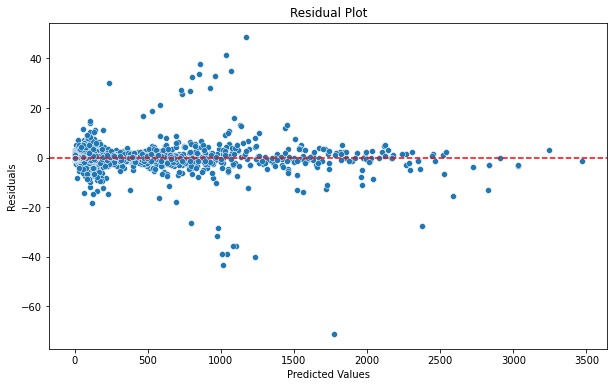

In [14]:
get_r2_score(y_val["time"], time_pred)
plot_residuals(y_val["time"], time_pred)

In [ ]:
"""
# 1. Calculate arithmetic intensity: I = op_flops / op_bytes
# 2. Calculate estimated FLOPs/sec: est_flops_sec = min(pi, alpha * beta * I)
# 3. Calculate estimated operator time: estimated_op_time = op_flops / est_flops_sec
#    This simplifies to: estimated_op_time = max(op_flops / pi, op_flops / (alpha * beta * I))
#    Further simplifying: estimated_op_time = max(op_flops / pi, op_bytes / beta)


This notebook approach:
1) take alpha to have some true theoretical value
2) Compute alpha from flops_per_sec (alpha * beta * I), EVEN IN THE CASE we're bounded by estimated_op_time
3) Pray that the learned model can give us the true performance.


"""